In [1]:
from argparse import Namespace
args = Namespace(
  num_classes=2139,
  embed_dim=512,
  decoder_embedding=384,
  in_channels=1,
  no_head = True,
  model_name='caformer_s36.sail_in22k_ft_in1k_384',
  
  pretrained=True,
  device='cuda',
  lr=1e-5,
  freeze_body=False,
  warmup_steps=4,
  # batchsize=32,
  n_instances=2,
  n_labels=56,
  grad_accumulation_steps=4,
  num_steps=1000, 
  num_epochs=100, 
  checkpointing_steps=50,
  save_path='./working/trained_models/oml/caformer_s36.sail_in22k_ft_in1k_384_nohead',
  pretrain_path='./working/trained_models/timm/caformer_s36.sail_in22k_ft_in1k_384',
)
config = dict(args._get_kwargs())

In [2]:
import torch
from tqdm import tqdm
import pandas as pd

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.miners.inbatch_nhard_tri import NHardTripletsMiner
from oml.samplers.balance import BalanceSampler
from oml.utils.download_mock_dataset import download_mock_dataset
from retrieval.transform import *

from lion_pytorch import Lion


# dataset_root = "input/classification/train"
# df_train = pd.read_csv('input/classification/train.csv').rename(columns={'image':'path'})
# dataset_root = "input/my_classify_data/full"
# df_train = pd.read_csv('input/my_classify_data/full.csv').rename(columns={'image':'path'})
dataset_root = "input/my_classify_data_v1/full"
df_train = pd.read_csv('input/my_classify_data_v1/full.csv').rename(columns={'image':'path'})
label_counts = df_train['label'].value_counts()
labels_to_keep = label_counts[label_counts >= 2].index
df_train = df_train[df_train['label'].isin(labels_to_keep)]
print(len(df_train))

train_dataset = DatasetWithLabels(
  df_train, dataset_root=None,
  transform=train_transform,
)
# criterion = TripletLossWithMiner(margin=0.1, miner=AllTripletsMiner(), need_logs=True)
# criterion = TripletLossWithMiner(margin=0.1, miner=NHardTripletsMiner(1, 3), need_logs=True)
criterion = TripletLossWithMiner(margin=None, miner=NHardTripletsMiner(1, 3), need_logs=True)
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=args.n_labels, n_instances=args.n_instances)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler)

863029


In [3]:
next(iter(train_loader))['input_tensors'][:, [0]].shape

torch.Size([112, 1, 64, 64])

In [4]:
from retrieval.oml.timm_extractor import TimmExtractor, create_timm_body
from classification.ml_decoder.ml_decoder.ml_decoder import MLDecoder
from fastai.vision.learner import _update_first_layer, has_pool_type, create_head, num_features_model
import torch.nn as nn
from copy import deepcopy
from torch.optim import AdamW, SGD
from lion_pytorch import Lion
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

extractor = TimmExtractor(args.model_name, config)
extractor.train()
opt = Lion(extractor.parameters(), lr=args.lr, weight_decay=1e-2)
# opt = AdamW(model.parameters(), lr=args.lr/10)
# opt = SGD(model.parameters(), lr=args.lr)
warmup = LinearLR(opt, start_factor=1/args.warmup_steps, total_iters=args.warmup_steps)
reduce = CosineAnnealingLR(opt, T_max=args.num_epochs * len(train_loader))
scheduler = SequentialLR(opt, [warmup, reduce], milestones=[args.warmup_steps])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/caformer_s36.sail_in22k_ft_in1k_384)
INFO:timm.models._hub:[timm/caformer_s36.sail_in22k_ft_in1k_384] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [5]:

body = create_timm_body(args.model_name, pretrained=False, n_in=args.in_channels)
nf = num_features_model(body)
ml_decoder_head = MLDecoder(args.num_classes, initial_num_features=nf, decoder_embedding=768)
model = nn.Sequential(body, ml_decoder_head)

import os
import torch
if os.path.isfile(os.path.join(args.pretrain_path, 'pytorch_model.bin')):
  best_score, state_dict = torch.load(os.path.join(args.pretrain_path, 'pytorch_model.bin'))
  model.load_state_dict(state_dict)
  print('loaded pretrain weights')
  extractor.body = body

In [6]:
from utils import get_model_size
get_model_size(extractor)

'36.186M'

In [7]:
from sklearn.metrics import top_k_accuracy_score
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import cv2
import pandas as pd


min_score, max_score = 1e5, -1e5
def eval_model(mode=1):
  if mode == 0:
    eval_model = extractor
    db_vecs = []
    eval_model.to(args.device)

    for i in tqdm(range(252), position=0, leave=True):
      db_img = cv2.imread('input/2d3d/database/pairs/%d.png' % i)
      x = test_transform(image=db_img)['image'][[0], :, :]
      x = x.to(args.device)[None]
      eval_model.eval()
      with torch.no_grad():
        db_vec = eval_model(x)
      db_vec = db_vec.detach().cpu().numpy()
      db_vecs += [db_vec]

    def score_query(q_vec):
      db_scores = []
      for i in range(252):
        db_vec = db_vecs[i]
        db_scores += [-((db_vec - q_vec) ** 2).sum()]
      return db_scores
      
    labels = pd.read_csv('input/2d3d/labels.csv')

    def eval_retrieve():
      global min_score, max_score
      min_score, max_score = 1e5, -1e5
      scores = []
      mean_scores = []
      for i in tqdm(range(252), position=0, leave=True):
        q_img = cv2.imread('input/2d3d/queries/%d.png' % i)
        x = test_transform(image=q_img)['image'][[0], :, :]
        x = x.to(args.device)[None]
        eval_model.eval()
        with torch.no_grad():
          q_vec = eval_model(x)
        q_vec = q_vec.detach().cpu().numpy()
        db_scores = score_query(q_vec)
        min_score = min(min_score, np.min(db_scores))
        max_score = max(max_score, np.max(db_scores))
        mean_scores += [np.mean(db_scores)]
        rank = np.argsort(db_scores)[::-1]
        
        label = list(map(int, (labels.loc[labels['query'] == '%d.png' % i].label.iloc[0]).replace('.stl', '').split(',')))
        min_rel = 1000
        for rel in label:
          min_rel = min(np.where(rank==rel)[0].item(), min_rel)
        curr_score = 1 / (min_rel + 1) if min_rel < 5 else 0
        # curr_score = any(rank[j]==i for j in range(1))
        scores += [curr_score]
      print(min_score, np.mean(mean_scores), max_score)
      return np.mean(scores)
    return eval_retrieve()
    
  
  
  db_vecs = []
  eval_model = extractor
  eval_model.cuda()

  num_keys = len(os.listdir('input/2d3d/pairs/stl/pairs/'))
  num_queries = len(os.listdir('input/2d3d/pairs/print/'))
  for i in tqdm(range(num_keys), position=0, leave=True):
    db_img = cv2.imread('input/2d3d/pairs/stl/pairs/%d.png' % i)
    x = test_transform(image=db_img)['image'][[0], :, :]
    x = x.cuda()[None]
    eval_model.eval()
    with torch.no_grad():
      db_vec = eval_model(x)
    db_vec = db_vec.detach().cpu().numpy()
    db_vecs += [db_vec]

  def score_query(q_vec):
    db_scores = []
    for i in range(num_keys):
      db_vec = db_vecs[i]
      db_scores += [-((db_vec - q_vec) ** 2).mean().item()]
    return db_scores


  def eval_retrieve():
    scores = []
    for i in tqdm(range(num_queries), position=0, leave=True):
      q_img = cv2.imread('input/2d3d/pairs/print/%d.png' % i)
      x = test_transform(image=q_img)['image'][[0], :, :]
      x = x.cuda()[None]
      eval_model.eval()
      with torch.no_grad():
        q_vec = eval_model(x)
      q_vec = q_vec.detach().cpu().numpy()
      db_scores = score_query(q_vec)
      rank = np.argsort(db_scores)[::-1]
      # print(np.where(rank==i)[0].item())
      curr_score = any(rank[j]==i for j in range(1))
      scores += [curr_score]
    return np.mean(scores)
  return eval_retrieve()
    

In [8]:
import torch
import os

def save_model(step, best_score):
  save_dir = os.path.join(args.save_path, 'ckpt%d'%step)
  os.makedirs(args.save_path, exist_ok=True)
  # torch.save((best_score, extractor.state_dict()), os.path.join(save_dir, 'pytorch_model.bin'))
  torch.save((best_score, extractor.state_dict()), os.path.join(args.save_path, 'pytorch_model.bin'))

def load_model(prev_score):
  if os.path.isfile(os.path.join(args.save_path, 'pytorch_model.bin')):
    best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))
    if best_score > prev_score:
      extractor.load_state_dict(state_dict)
      print('loaded')
      prev_score = best_score
  return prev_score

In [9]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [10]:
mrr = eval_model()
print(mrr)

 71%|███████▏  | 163/228 [00:03<00:01, 51.26it/s]

In [ ]:
best_score = load_model(0.0)
if best_score > 0.0:
  mrr = eval_model(0)
  print(mrr)
  mrr = eval_model()
  print(mrr)

loaded


100%|██████████| 252/252 [00:04<00:00, 54.66it/s]


-643.5823 -251.54356 -3.2927847
0.935978835978836


100%|██████████| 228/228 [00:04<00:00, 55.99it/s]


0.8991228070175439


In [ ]:
# 0.8991228070175439

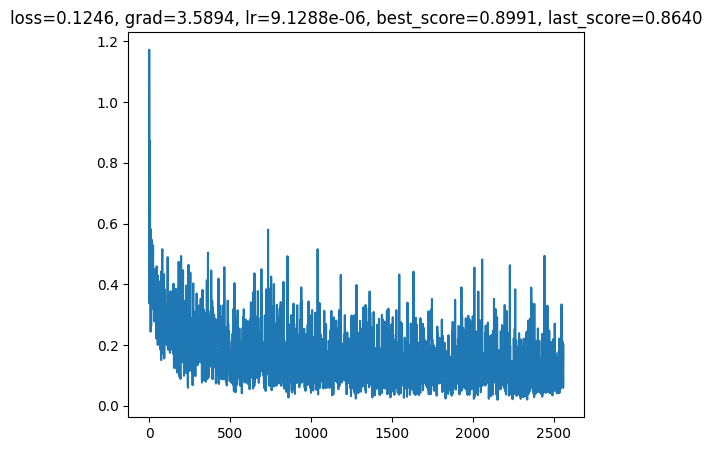

loss=0.1246, grad=3.5894, lr=9.1288e-06, best_score=0.8991, last_score=0.8640:  10%|█         | 14/134 [00:15<01:13,  1.63it/s]

In [ ]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score

plot = True
plot_every = 20

losses = []
accs = []
grads = []
model.to(args.device)
step = 0
best_score = 0.0
last_score = 0.0

best_score = load_model(best_score)
last_score = best_score
extractor.cuda()
for epoch in range(1, args.num_epochs + 1):
  pbar = tqdm(train_loader, position=0, leave=True)
  
  for batch in pbar:
    extractor.train()
    
    for k in batch:
      if k not in ['input_tensors', 'labels']: continue
      if isinstance(batch[k], torch.Tensor):
        batch[k] = batch[k].cuda()
    embeddings = extractor(batch["input_tensors"][:, [0]])
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    try:
      loss = criterion(embeddings, batch["labels"])
      if torch.isinf(loss).sum().item() > 0:
        print("Loss is inf")
        assert False, "Loss is infinite"
      pass
    except :
      del batch
      del embeddings
      continue
    loss.backward()
    grad = torch.nn.utils.clip_grad_norm_(extractor.parameters(), 1.0)
    # assert grad.item() > 1e-9, "Grad is zero. Model not learning."
    losses += [loss.item()]
    grads += [grad.item()]
    opt.step()
    scheduler.step()
    opt.zero_grad()
    step += 1
    
    
    if plot and step % plot_every == 0: 
      clear_output(True)
      plt.figure(figsize=(20, 5))
      plt.subplot(131)
      plt.title('loss=%.4f, grad=%.4f, lr=%.4e, best_score=%.4f, last_score=%.4f' % (
      np.mean(losses[-32:]), np.mean(grads[-16:]), scheduler.get_last_lr()[-1], best_score, last_score))
      plt.plot(losses)
      plt.show()
      
    pbar.set_description_str('loss=%.4f, grad=%.4f, lr=%.4e, best_score=%.4f, last_score=%.4f' % (
      np.mean(losses[-32:]), np.mean(grads[-16:]), scheduler.get_last_lr()[-1], best_score, last_score))
    if step % args.checkpointing_steps == 0:
      score = eval_model()
      print("Score: %.4f" % (score))
      last_score = score
      if score > best_score:
        save_model(step, score)
        best_score = score
        print('New best: %.4f' % score)
      # save_model(os.path.join(args.save_path, 'checkpoint_%d' % step))
    del batch
  
  # score = eval_model()
  # print("Score: %.4f" % (score))
  # last_score = score
  # if score > best_score:
  #   save_model(step, score)
  #   best_score = score
  #   print('New best: %.4f' % score)
  